In [1]:
%matplotlib inline

In [2]:
import numpy as np

def _idcg(l):
    return sum((1.0 / np.log(i + 2) for i in range(l)))

_idcgs = [_idcg(i) for i in range(101)]

def ndcg(gt, rec):
    dcg = 0.0
    for i, r in enumerate(rec):
        if r in gt:
            dcg += 1.0 / np.log(i + 2)

    return dcg / _idcgs[len(gt)]

In [3]:
import enum

class QuestionType(enum.Enum):
    ALL = enum.auto()
    SONG_TAG = enum.auto()
    SONG_TITLE = enum.auto()
    TAG_TITLE = enum.auto()
    SONG_ONLY = enum.auto()
    TAG_ONLY = enum.auto()
    TITLE_ONLY = enum.auto()
    NOTHING = enum.auto()

QUESTION_TYPE_MAP = {
    # (songs, tags, title): question_type
    (True, True, True): QuestionType.ALL,
    (True, True, False): QuestionType.SONG_TAG,
    (True, False, True): QuestionType.SONG_TITLE,
    (False, True, True): QuestionType.TAG_TITLE,
    (True, False, False): QuestionType.SONG_ONLY,
    (False, True, False): QuestionType.TAG_ONLY,
    (False, False, True): QuestionType.TITLE_ONLY,
    (False, False, False): QuestionType.NOTHING,
}

def get_question_type(question):
    songs = question['songs']
    tags = question['tags']
    title = question['plylst_title']

    has_songs = len(songs) > 0
    has_tags = len(tags) > 0
    has_title = title != ""

    return QUESTION_TYPE_MAP[has_songs, has_tags, has_title]

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from statistics import mean


def print_score(music_ndcgs, tag_ndcgs, scores):
    music_ndcg = mean(music_ndcgs)
    tag_ndcg = mean(tag_ndcgs)
    score = mean(scores)

    print(f"Music nDCG: {music_ndcg:.6}")
    print(f"Tag nDCG: {tag_ndcg:.6}")
    print(f"Score: {score:.6}")


def evaluate(results, questions, answers):
    if len(results) < len(answers):
        print("[Warning] 제출한 정답이 부족합니다.")

    questions_dict = {p['id']: p for p in questions}
    answers_dict = {p['id']: p for p in answers}

    total_music_ndcgs = list()
    total_tag_ndcgs = list()
    total_scores = list()

    case_music_ndcgs = defaultdict(list)
    case_tag_ndcgs = defaultdict(list)
    case_scores = defaultdict(list)

    for p in results:
        pid = p['id']
        songs = p['songs']
        tags = p['tags']

        if pid not in questions_dict:
            raise Exception(f"questions에 없습니다: {pid}")
        if pid not in answers_dict:
            raise Exception(f"answers 없습니다: {pid}")

        question = questions_dict[pid]
        answer = answers_dict[pid]
        question_type = get_question_type(question)

        # Validate playlist
        if len(songs) != 100:
            raise Exception(f"추천 곡 결과의 개수가 맞지 않습니다: {pid}")
        if len(tags) != 10:
            raise Exception(f"추천 태그 결과의 개수가 맞지 않습니다: {pid}")
        if len(set(songs)) != 100:
            raise Exception(f"한 플레이리스트에 중복된 곡 추천은 허용되지 않습니다: {pid}")
        if len(set(tags)) != 10:
            raise Exception(f"한 플레이리스트에 중복된 태그 추천은 허용되지 않습니다: {pid}")

        cur_music_ndcg = ndcg(answer['songs'], songs)
        cur_tag_ndcg = ndcg(answer['tags'], tags)
        cur_score = cur_music_ndcg * 0.85 + cur_tag_ndcg * 0.15

        # Update total score
        total_music_ndcgs.append(cur_music_ndcg)
        total_tag_ndcgs.append(cur_tag_ndcg)
        total_scores.append(cur_score)

        # Update case score
        case_music_ndcgs[question_type].append(cur_music_ndcg)
        case_tag_ndcgs[question_type].append(cur_tag_ndcg)
        case_scores[question_type].append(cur_score)

    return (
        total_music_ndcgs, total_tag_ndcgs, total_scores,
        case_music_ndcgs, case_tag_ndcgs, case_scores,
    )


def print_scores(
        total_music_ndcgs, total_tag_ndcgs, total_scores,
        case_music_ndcgs, case_tag_ndcgs, case_scores,
    ):
    print("=== Total score ===")
    print_score(total_music_ndcgs, total_tag_ndcgs, total_scores)

    for question_type in QuestionType:
        if question_type not in case_music_ndcgs:
            continue

        print(f"=== {question_type.name} score ===")
        print_score(case_music_ndcgs[question_type], case_tag_ndcgs[question_type], case_scores[question_type])


def create_histogram(music_ndcgs, tag_ndcgs, scores, bins=np.linspace(0, 1, 10)):
    # plt.hist([music_ndcgs, tag_ndcgs, scores], bins, label=["music_ndcgs", "tag_ndcgs", "score"])
    plt.hist([music_ndcgs, tag_ndcgs], bins, alpha=1, label=["music_ndcgs", "tag_ndcgs"])
    plt.hist(scores, bins, alpha=0.33, label="score")
    plt.legend(loc='upper right')

In [5]:
from utils import read_json

In [6]:
questions = read_json('./arena_data/questions/val.json')
answers = read_json('./arena_data/answers/val.json')
results = read_json('./arena_data/results/results.json')

In [7]:
(total_music_ndcgs, total_tag_ndcgs, total_scores,
    case_music_ndcgs, case_tag_ndcgs, case_scores) = evaluate(results, questions, answers)

In [8]:
print_scores(
    total_music_ndcgs, total_tag_ndcgs, total_scores,
    case_music_ndcgs, case_tag_ndcgs, case_scores,
)

=== Total score ===
Music nDCG: 0.211886
Tag nDCG: 0.445369
Score: 0.246908
=== SONG_TAG score ===
Music nDCG: 0.365335
Tag nDCG: 0.486065
Score: 0.383445
=== TAG_TITLE score ===
Music nDCG: 0.0805532
Tag nDCG: 0.47563
Score: 0.139815
=== SONG_ONLY score ===
Music nDCG: 0.321968
Tag nDCG: 0.476737
Score: 0.345183
=== TITLE_ONLY score ===
Music nDCG: 0.0796872
Tag nDCG: 0.343042
Score: 0.11919


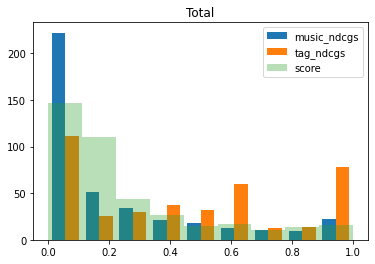

In [9]:
plt.title("Total")
create_histogram(total_music_ndcgs, total_tag_ndcgs, total_scores)
plt.show()

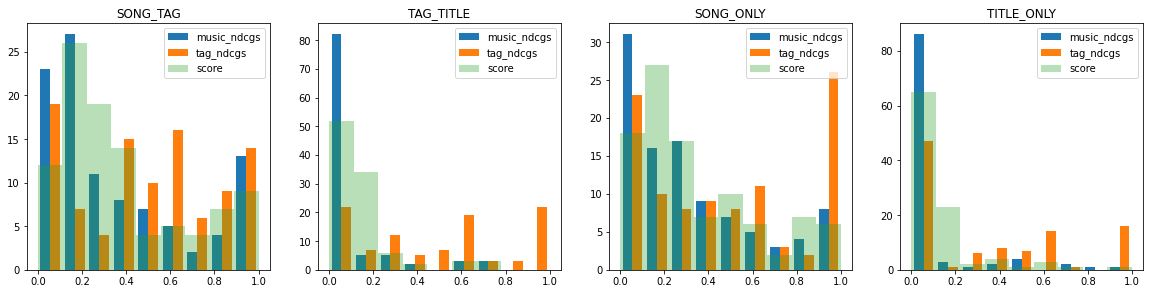

In [10]:
plt.figure(figsize=(20, 10))
i = 1
for question_type in QuestionType:
    if question_type not in case_music_ndcgs:
        continue

    plt.subplot(2,4,i)
    plt.title(question_type.name)
    create_histogram(case_music_ndcgs[question_type], case_tag_ndcgs[question_type], case_scores[question_type])
    i += 1
plt.show()